## Using NLP predict whether the review is positive or negative for a given dataset 

### Data Preprocessing

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/admin1/PycharmProjects/Machine Learning using libraries/')
from ipynb.fs.full.ml_library import *
import os
os.chdir('/home/admin1/PycharmProjects/Machine Learning using libraries/Classification/Datasets & pickled objects/')

# loading dataset from csv file & storing it as pandas dataframe
twitter_data = pd.read_csv('tweets.csv', encoding='ISO-8859-1' ,names=['class', 'id', 'date', 'query', 'name', 'tweet'])
twitter_data.head()

,class,id,date,query,name,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [2]:
data1 = twitter_data[:2000]
data2 = twitter_data[-2000:]

In [3]:
data = data1.append(data2)

In [4]:
data.shape

(4000, 6)

In [5]:
data.reset_index(inplace=True)

In [6]:
data.columns

Index(['index', 'class', 'id', 'date', 'query', 'name', 'tweet'], dtype='object')

#### Data cleansing

In [7]:
# removing stopwords & getting root words for remaining
feature = 'tweet'
corpus = get_corpus(data, feature)

#### Creating count vectoriser i.e. mapping count of a word vs each record 

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
#if we want to define maximum features to be considered
# cv = CountVectorizer(max_features=1500)  # selected 1500 most frequent 1500 features/words

#### Creating features matrix & target variable array

In [9]:
x_values = cv.fit_transform(corpus).toarray()

label = 'class'
y_values = data[label].values

x_values.shape, y_values.shape

((4000, 7873), (4000,))

In [10]:
y_values = np.where(y_values > 0, 1, 0)

#### Splitting dataset into train set & test set

In [11]:
from sklearn.model_selection import train_test_split
train_x_values, test_x_values, train_y_values, test_y_values = train_test_split(x_values, y_values, train_size=0.8, random_state=0)

#### Importing different classifier models 

In [12]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import confusion_matrix, roc_curve, classification_report

In [13]:
classifiers = [LR, RF]
classifier_names = ['Logistic', 'RandomForest']

### Building & comparing different classification models using roc curve

AUC Logistic: 0.8041681514963958
AUC RandomForest: 0.7784008852711143


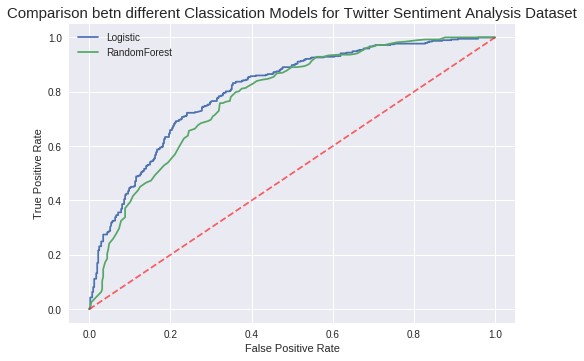

In [14]:
test_predictions = []
classifier_objects = []

plt.style.use('seaborn')
for index in range(len(classifiers)):
    classifier = classifiers[index](random_state= 0) 
    
    # Buiding model & prediting for test set
    classifier.fit(train_x_values, train_y_values)
    test_prediction = classifier.predict(test_x_values)
    
    # storing predictions for each classifier model & stoting classifier model
    test_predictions.append(test_prediction)
    classifier_objects.append(classifier)
    
    # Plotting ROC curve & printing AUC for each 
    test_predicted_probs = classifier.predict_proba(test_x_values)[:,1]
    fpr, tpr, _ = roc_curve(test_y_values, test_predicted_probs)
    calculate_auc(classifier_names[index], fpr, tpr)
    plt.plot(fpr, tpr, label=classifier_names[index])

plt.plot([0,1],[0,1], 'r--', alpha=0.6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison betn different Classication Models for Twitter Sentiment Analysis Dataset',fontdict={'fontsize':15})
plt.legend()
plt.show()

#### Logistic, RandomForest models are comparable 

#### We can consider which model to choose according to our goal

In [15]:
for index in range(0,len(classifiers)):
    print('<<<<<<<<<<<',classifier_names[index],'>>>>>>>>>>>','\n')
    print(f'Confusion matrix:\n {confusion_matrix(test_y_values, test_predictions[index])}\n')
    print(f'Classification report:\n {classification_report(test_y_values, test_predictions[index])}')

<<<<<<<<<<< Logistic >>>>>>>>>>> 

Confusion matrix:
 [[294 113]
 [105 288]]

Classification report:
               precision    recall  f1-score   support

           0       0.74      0.72      0.73       407
           1       0.72      0.73      0.73       393

    accuracy                           0.73       800
   macro avg       0.73      0.73      0.73       800
weighted avg       0.73      0.73      0.73       800

<<<<<<<<<<< RandomForest >>>>>>>>>>> 

Confusion matrix:
 [[265 142]
 [ 86 307]]

Classification report:
               precision    recall  f1-score   support

           0       0.75      0.65      0.70       407
           1       0.68      0.78      0.73       393

    accuracy                           0.71       800
   macro avg       0.72      0.72      0.71       800
weighted avg       0.72      0.71      0.71       800



#### Checking cross-validation score

In [16]:
from sklearn.model_selection import cross_val_score  
for index in range(0,len(classifiers)):
    print('<<<<<<<<<<<',classifier_names[index],'>>>>>>>>>>>')
    classifier = classifiers[index](random_state= 0)
    accuracies = cross_val_score(estimator=classifier, X=x_values, y=y_values, cv=10)
    print(f'Avg accuracy:{accuracies.mean()}, Std deviation: {accuracies.std()}\n')

<<<<<<<<<<< Logistic >>>>>>>>>>>
Avg accuracy:0.7152499999999999, Std deviation: 0.02370258424729251

<<<<<<<<<<< RandomForest >>>>>>>>>>>
Avg accuracy:0.6980000000000001, Std deviation: 0.01993113142799475



### Chosen Logistic model

### Using RandomizedSeach & GridSearch for finding optimal parameters

In [20]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
classifier = classifiers[0](random_state=0)

# defining hypermeters in list of dictionaries initially & changing these to optimal values after running this block of code
parameters = [{'C':[1,1.1,1.2,1.3,1.4]}]
# creating grid search object with paramters to try & 10-fold cross validation
grid_search = GridSearchCV(estimator=classifier, param_grid=parameters, scoring='accuracy', cv=10)

# fitting classifier model for given parameters for trial
grid_search = grid_search.fit(train_x_values, train_y_values)

# finding best accuracy & best parameters
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
best_accuracy, best_parameters

# unpacking hypermeters' optimal values to variable further will be feed to classifier model
C = list(best_parameters.values())[0]
best_parameters, C, best_accuracy

({'C': 1.2}, 1.2, 0.6968749999999999)

#### Cheking 10- fold validation score after optimal parameters

In [21]:
classifier = LR(random_state=0, C=C)
classifier.fit(train_x_values, train_y_values)
accuracies = cross_val_score(estimator=classifier, X=x_values, y=y_values, cv=10)
print(f'Avg accuracy:{accuracies.mean()}, Std deviation: {accuracies.std()}\n')

Avg accuracy:0.71575, Std deviation: 0.024699443313564783

